In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
import GPy
from IPython.display import display
import scipy
from scipy import stats
import pystan

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Load and clean the data

In [3]:
DATE_FORMAT = r'%d/%m/%Y'

mauna_loa = pandas.read_csv(r'./weekly_in_situ_co2_mlo_data_only.csv')
first_day = datetime.strptime(mauna_loa['ds'][0], r'%d/%m/%Y')
mauna_loa['day'] = [(datetime.strptime(date_string, DATE_FORMAT) - first_day).days
                    for date_string in mauna_loa['ds']]

day_range = max(mauna_loa['day']) - min(mauna_loa['day'])
mauna_loa['norm_day'] = mauna_loa['day'] / day_range

y_min = min(mauna_loa['y'])
y_range = max(mauna_loa['y']) - y_min
mauna_loa['norm_y'] = (mauna_loa['y'] - y_min)/ y_range

mauna_loa.head()

,ds,y,day,norm_day,norm_y
0,29/03/1958,316.19,0,0.000000,0.032427
1,05/04/1958,317.31,7,0.000322,0.043957
2,12/04/1958,317.69,14,0.000643,0.047869
3,19/04/1958,317.58,21,0.000965,0.046737
4,26/04/1958,316.48,28,0.001286,0.035413


In [4]:
mauna_loa.to_csv('./cleaned_mauna_loa_data.csv')

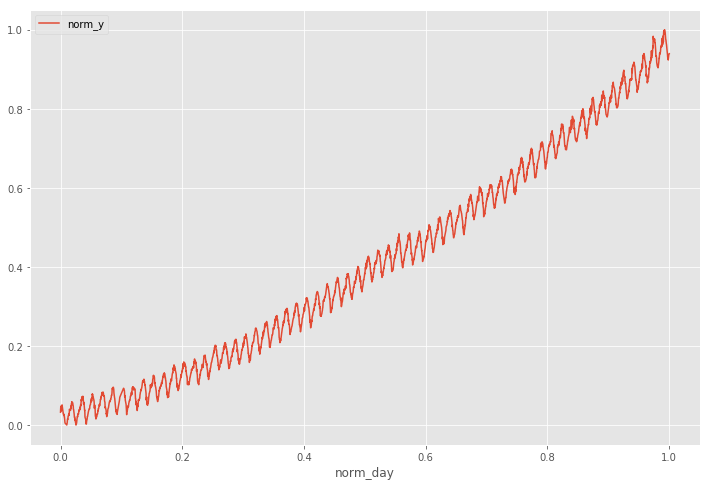

In [54]:
mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8))

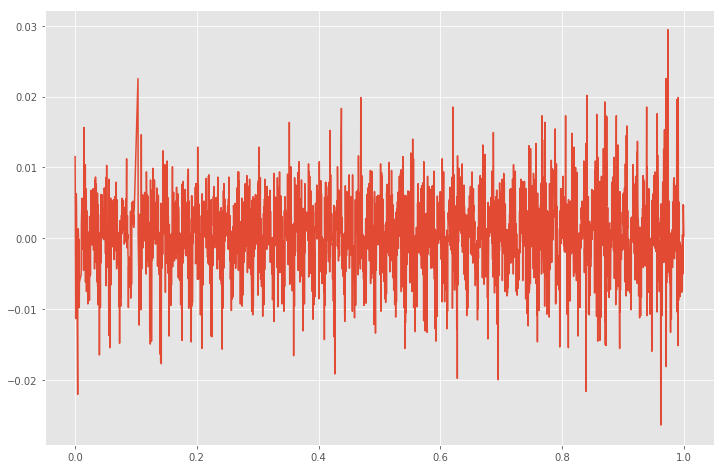

In [55]:
y_diffs = [y - x for x, y in zip(mauna_loa['norm_y'], mauna_loa['norm_y'][1:])] 
plt.figure(figsize=(12, 8))
plt.plot(mauna_loa['norm_day'][1:], y_diffs)


In [42]:
TRAIN_SIZE = 1040
train = mauna_loa[:TRAIN_SIZE]
test = mauna_loa[TRAIN_SIZE:]

# TEST_SIZE = 52 * 8
# train = mauna_loa[:-TEST_SIZE]
# test = mauna_loa[-TEST_SIZE:]

## Start with a very naive Stan model 

In [45]:
local_linear_model = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days 
}

parameters {
    real alpha;    // linear regression intercept
    real beta;     // linear regression slope
    real<lower=0> sigma_lr; // linear regression slope
    real<lower=0, upper=1> rho;      // local trend learning rate

    real delta[N];               // slope at time t    
    real<lower=0> sigma_mu;      // standard deviation of the observation noise 
    real<lower=0> sigma_delta;   // standard deviation of the observation noise 
    
    // real mu;
    // real<lower=0> tau;
    
}
/*
transformed parameters {
    
    
    for (j in 1:J)
    theta[j] = mu + tau * eta[j];
}
*/

model {
    alpha ~ normal(0, 0.1);
    beta ~ normal(0, 0.1);
    sigma_lr ~ gamma(1, 0.1);
    rho ~ normal(0.1, 0.03);
    
    y ~ normal(alpha + t * beta, sigma_lr);

    sigma_delta ~ gamma(1, 0.1);
    sigma_mu ~ gamma(1, 0.1);

    delta[1] ~ normal(y[1], sigma_delta);
    y[1] ~ normal(delta[1], sigma_mu);
    
    for (i in 2:N) {
        delta[i] ~ normal(beta + rho * (delta[i - 1] - beta), sigma_delta);
        y[i] ~ normal(y[i - 1] + delta[i], sigma_mu);
    }
}

generated quantities {
  real delta_future[N_future];
  real y_future[N_future];
  
  delta_future[1] = normal_rng(delta[N], sigma_delta);
  y_future[1] = normal_rng(delta_future[1], sigma_mu);
  
  for(i in 2:N_future) {
    delta_future[i] = normal_rng(beta + rho * (delta_future[i - 1] - beta), sigma_delta);
    y_future[i] = normal_rng(y_future[i - 1] + delta_future[i], sigma_mu);
  }
}
"""

llm = pystan.StanModel(model_code=local_linear_model, model_name='local_linear', verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL local_linear_67a0253b9236169ea3ce96de1d04cc96 NOW.
INFO:pystan:OS: darwin, Python: 3.6.3 |Anaconda custom (x86_64)| (default, Nov  3 2017, 12:34:11) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)], Cython 0.25.2


Compiling /var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn/T/tmpmxqg76yp/stanfit4local_linear_67a0253b9236169ea3ce96de1d04cc96_1026378185330080167.pyx because it changed.
[1/1] Cythonizing /var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn/T/tmpmxqg76yp/stanfit4local_linear_67a0253b9236169ea3ce96de1d04cc96_1026378185330080167.pyx
building 'stanfit4local_linear_67a0253b9236169ea3ce96de1d04cc96_1026378185330080167' extension
creating /var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn/T/tmpmxqg76yp/var
creating /var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn/T/tmpmxqg76yp/var/folders
creating /var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn/T/tmpmxqg76yp/var/folders/j9
creating /var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn/T/tmpmxqg76yp/var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn
creating /var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn/T/tmpmxqg76yp/var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn/T
creating /var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn/T/tmpmxqg76yp/var/folders/j9/9f76zhzd1ldf1jcmp7t

In [46]:
local_linear_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
}

fit = llm.sampling(data=local_linear_data, iter=1000, chains=2, n_jobs=2, 
                  init=lambda: {'sigma_delta': 0.05, 'sigma_mu': 0.05, 'sigma_lr': 0.05, 'rho': 0.1})

fit

In [47]:
fit

Inference for Stan model: local_linear_67a0253b9236169ea3ce96de1d04cc96.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha              8.3e-3  4.9e-5 1.4e-3 5.6e-3 7.3e-3 8.3e-3 9.3e-3   0.01    806    1.0
beta                 0.61  2.3e-4 6.6e-3    0.6   0.61   0.61   0.62   0.62    800    1.0
sigma_lr             0.02  1.5e-5 4.9e-4   0.02   0.02   0.02   0.02   0.02   1000    nan
rho                   1.0  1.4e-6 4.3e-5    1.0    1.0    1.0    1.0    1.0   1000    nan
delta[0]             0.03  4.0e-5 1.3e-3   0.02   0.03   0.03   0.03   0.03   1000    1.0
delta[1]             0.02  4.9e-5 1.6e-3   0.02   0.02   0.02   0.02   0.02   1000    1.0
delta[2]             0.01  5.5e-5 1.7e-3   0.01   0.01   0.01   0.02   0.02   1000    1.0
delta[3]           9.2e-3  5.9e-5 1.9e-3 5.2e-3 8.0e-3 9.3e-3   0.01   0.01   1000    1.0
d

In [48]:
samples = fit.extract()

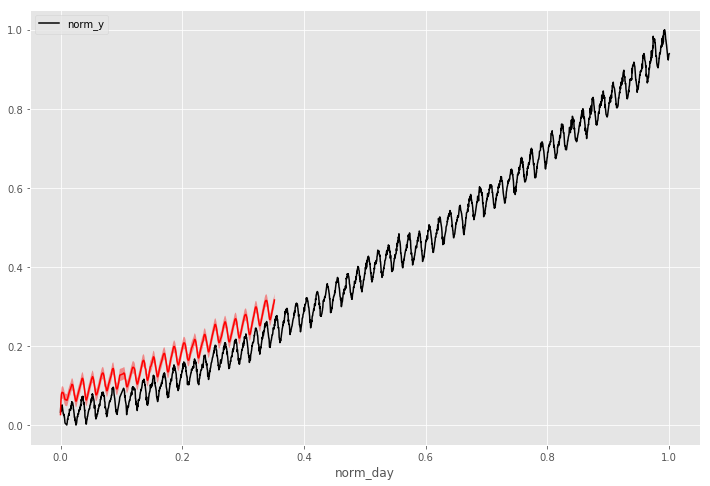

In [51]:
def plot_samples(samples, future=200):
    delta_means = np.mean(samples['delta'], axis=0)
    delta_stds = np.std(samples['delta'], axis=0)
    noise = delta_stds + np.mean(samples['sigma_delta']) + np.mean(samples['sigma_mu'])
    y = [delta_means[0]]
    for d in delta_means[1:]:
        y.append(y[-1] + d)
        
    y = np.asarray(y)
        
    ax = mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8), color='black')
    ax.plot(train['norm_day'], y, color='red')
    ax.fill_between(train['norm_day'], y - 2 * noise, y + 2 * noise, alpha=0.4, 
                          facecolor='red')
    
#     y_future_means = np.mean(samples['y_future'], axis=0)
#     y_future_stds = np.std(samples['y_future'], axis=0)
    
#     ax.plot(test['norm_day'][:future], y_future_means[:future], color='blue')
#     ax.fill_between(test['norm_day'][:future], y_future_means[:future] - 2 * y_future_stds[:future], 
#                     y_future_means[:future] + 2 * y_future_stds[:future], alpha=0.4, facecolor='blue')
    
    plt.show()

plot_samples(samples)

In [13]:
samples['y_future'].shape

(1000, 416)

In [14]:
test.shape

(416, 5)

In [26]:
np.std(samples['y_future'], axis=0).shape

(416,)

In [30]:
np.std(samples['y_future'][:,-1])

6.0723059273803051

In [31]:
samples['y_future'][:,-1]

array([  7.94860145e-01,   5.00984030e+00,   5.65619175e+00,
         5.58491729e+00,   9.20900288e-01,  -5.15357053e+00,
         9.74934315e+00,   1.49879029e+00,   3.61864476e+00,
         4.45486681e+00,   3.68130168e-01,   4.09167833e+00,
         3.59032420e+00,  -4.91874173e+00,   1.67969199e+00,
         1.05573143e+00,   1.21100063e+01,  -2.79374824e+00,
        -8.44219622e+00,   1.13401435e+00,   4.69835906e+00,
         7.73246828e-01,  -3.46912661e+00,  -2.94122799e+00,
        -5.49074167e+00,   5.92975668e+00,   2.31819069e+00,
         2.54963667e+00,   2.15363893e+00,  -7.20889855e+00,
         4.68640802e+00,   9.72499146e-01,  -9.20102189e+00,
         1.01600697e+01,   6.45925746e+00,   5.30407234e+00,
        -2.67956776e+00,  -1.38351831e+00,   4.59404576e+00,
         3.63611019e+00,   3.11696559e+00,   7.64722338e+00,
         5.16587763e+00,   1.02890099e+01,  -6.69856580e+00,
        -4.69194410e+00,   1.59290672e+00,   1.70274610e+00,
        -3.63598691e+00,